# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime
import random
from scipy import stats
from scipy.stats import norm

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.style as style
style.use('fivethirtyeight')

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import PowerTransformer

# Modelling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Loading the Training & Testing Dataset

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.set_index('Id')
test = test.set_index('Id')

In [4]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [5]:
train.shape

(1460, 80)

# Exploratory Data Analysis

### Analysing the Target Variable, SalePrice

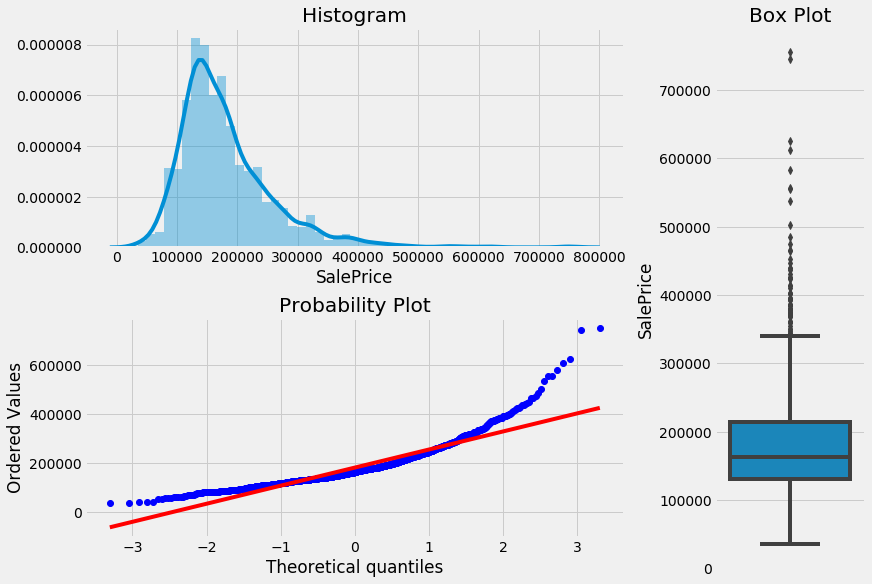

In [6]:
def plotting_3_chart(df, feature):

    # Creating a customized chart and defining the layout. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    # creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # Customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('QQ_plot') 
    stats.probplot(df.loc[:,feature], plot = ax2)

    # Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train, 'SalePrice')

#### We can see that our predictor variable is right-skewed. The measure of the skew can be determined by looking at the Skewness and Kurtosis metrics for this variable.

In [7]:
# Skewness and Fisher's Kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### Ideally, for a Standard Normal distribution, Skewness and Fisher's Kurtosis should be equal to 0. The assumptions of a Linear Regression model include that Multivariate Normality and Homoscedasticity. Since that is not the case for SalePrice, we will need to normalize this variable (and any other variables which are skewed) before we train our model.

### Correlation of Features

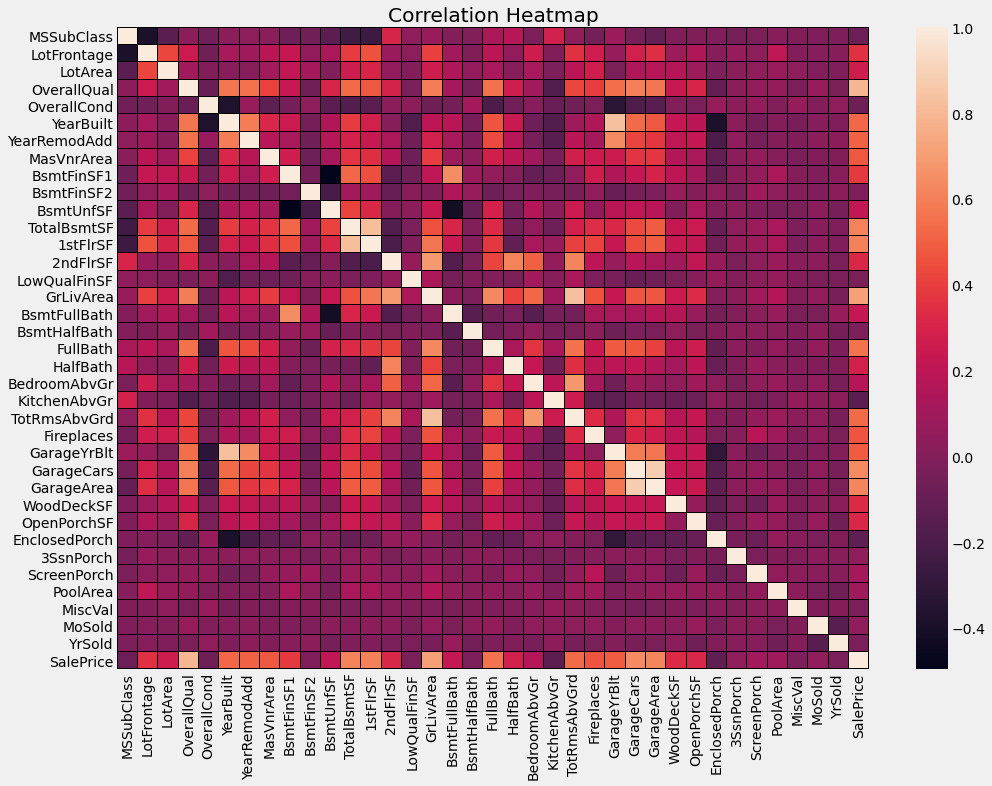

In [6]:
correlations= train.corr(method='pearson')
plt.figure(figsize=(15,11))
sns.heatmap(correlations,linewidths=0.005,linecolor='k')
plt.title('Correlation Heatmap')
plt.show()

##### Estimating the Top 10 Correlated features with SalePrice

In [8]:
(train.corr()**2)["SalePrice"].sort_values(ascending = False)[1:].head(10)

OverallQual     0.625652
GrLivArea       0.502149
GarageCars      0.410124
GarageArea      0.388667
TotalBsmtSF     0.376481
1stFlrSF        0.367057
FullBath        0.314344
TotRmsAbvGrd    0.284860
YearBuilt       0.273422
YearRemodAdd    0.257151
Name: SalePrice, dtype: float64

## Feature Engineering

### Separating the Predictor Variable, SalePrice, to apply the feature transformations to the training and testing dataset.

In [9]:
Y = train['SalePrice'].reset_index(drop=True) #Saleprice column
X = train.drop(['SalePrice'], axis=1) #Remaining Training dataset

In [10]:
X.shape, Y.shape

((1460, 79), (1460,))

In [11]:
X.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal


In [12]:
test.shape

(1459, 79)

In [13]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
test.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [15]:
#Combining the training and the testing dataset for feature transformations
combined_dataset = X.append(test, sort=False)

combined_dataset.head(4)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml


In [16]:
combined_dataset.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [17]:
combined_dataset.iloc[1459,:] #1459 is the index of the last row from the training dataset in the combined dataset.

MSSubClass            20
MSZoning              RL
LotFrontage           75
LotArea             9937
Street              Pave
Alley                NaN
LotShape             Reg
LandContour          Lvl
Utilities         AllPub
LotConfig         Inside
LandSlope            Gtl
Neighborhood     Edwards
Condition1          Norm
Condition2          Norm
BldgType            1Fam
HouseStyle        1Story
OverallQual            5
OverallCond            6
YearBuilt           1965
YearRemodAdd        1965
RoofStyle          Gable
RoofMatl         CompShg
Exterior1st      HdBoard
Exterior2nd      HdBoard
MasVnrType          None
MasVnrArea             0
ExterQual             Gd
ExterCond             TA
Foundation        CBlock
BsmtQual              TA
                  ...   
HalfBath               1
BedroomAbvGr           3
KitchenAbvGr           1
KitchenQual           TA
TotRmsAbvGrd           6
Functional           Typ
Fireplaces             0
FireplaceQu          NaN
GarageType        Attchd


In [18]:
# Transforming the non-numeric predictors, which are stored as numbers and converting them into strings 

def type_transform (df):
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['YearBuilt'] = df['YearBuilt'].astype(str)
    df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)
    df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)
    df['OverallQual'] = df['OverallQual'].astype(str)
    df['OverallCond'] = df['OverallCond'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)

    return df

In [19]:
type_transform(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml


### Estimating Missing Values

In [20]:
#Missing Data

def missing_percentage (df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage""" 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [21]:
missing_percentage(combined_dataset)

,Total,Percent
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageCond,159,5.45
GarageQual,159,5.45
GarageFinish,159,5.45
GarageType,157,5.38


In [22]:
#Dropping columns with more than 90% missing values from the Combined Dataset

del combined_dataset['PoolQC']
del combined_dataset['MiscFeature']
del combined_dataset['Alley']

In [23]:
combined_dataset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,NaN,0,12,2008,WD,Normal


In [24]:
combined_dataset.shape

(2919, 76)

### Missing Value Treatment

In [25]:
def treat_missing (df):
    #The data description states that NA in the column Functional refers to typical ('Typ') values
    df['Functional'] = df['Functional'].fillna('Typ')
    
    #Replacing missing values in the following columns having categorical data with the mode of the column. These columns
    #features that are typically found in any house.
    for column in ['Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType', 'Utilities']:
        df[column].fillna(df[column].mode()[0], inplace=True)
        
    #The following features relate to the Basement of the house. NA values in these columns refer to the absence of a 
    #basement. Hence, we will replace the missing values in all the categorical variables as None, and in the numerical and
    #Boolean variables as 0.
    for column in ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']:
        df[column] = df[column].fillna('None')
    for column in ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:    
        df[column] = df[column].fillna(0)
        
    #The following features relate to the Garage of the house. NA values in these columns refer to the absence of a 
    #Garage. We will replicate the treatment that we used for the missing values for the Basement features here.
    for column in ['GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
        df[column] = df[column].fillna('None')
    for column in ['GarageArea', 'GarageCars', 'GarageYrBlt']:
        df[column] = df[column].fillna(0)
        
    #The following features relate to the masonry veneer walls of the house. NA values in these columns refer to the absence
    #of a masonry veneer wall.
    df['MasVnrType'] = df['MasVnrType'].fillna('None')
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    
    #For handling missing values in the MSZoning column, we look at the corresponding value in the MSSubClass column, and
    #replace the missing values by the mode of the values in the MSZoning column against the value in the MSSubClass column.
    df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    #For the following categorical features, according to the data dictionary, missing values indicate the absence of the 
    #feature in the house. Hence, we will replace all the missing values with None.
    for column in ['Fence', 'FireplaceQu']:
        df[column] = df[column].fillna('None')
    
    #Filling missing values in LotFrontage using the median of the coloumn corresponding to the neighborhood
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        
    return df
    

In [26]:
treat_missing(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,None,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,None,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,None,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,None,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,None,0,12,2008,WD,Normal
6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,MnPrv,700,10,2009,WD,Normal
7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,None,0,8,2007,WD,Normal
8,60,RL,80.0,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,None,350,11,2009,WD,Normal
9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,None,0,4,2008,WD,Abnorml


In [27]:
missing_percentage(combined_dataset) #checking for any missing values again

,Total,Percent


### Adding New Numerical Features

In [28]:
def add_numerical_features(df):
    #Total Bathrooms
    df['TotBathrooms'] = df['FullBath'] + (df['HalfBath']*0.5) + df['BsmtFullBath'] + (df['BsmtHalfBath']*0.5)
    #Total Surface Area
    df['TotalSF'] = (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])
    #Total Porch Surface Area
    df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])
    
    return df

In [29]:
add_numerical_features(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotBathrooms,TotalSF,Total_porch_sf
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,0,2,2008,WD,Normal,3.5,2566.0,61
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,None,0,5,2007,WD,Normal,2.5,2524.0,298
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,None,0,9,2008,WD,Normal,3.5,2706.0,42
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,None,0,2,2006,WD,Abnorml,2.0,2473.0,307
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,None,0,12,2008,WD,Normal,3.5,3343.0,276
6,50,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,MnPrv,700,10,2009,WD,Normal,2.5,2158.0,390
7,20,RL,75.0,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,0,8,2007,WD,Normal,3.0,3380.0,312
8,60,RL,80.0,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,None,350,11,2009,WD,Normal,3.5,3197.0,667
9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,0,4,2008,WD,Abnorml,2.0,2726.0,295


### Transforming the features to remove Skew using Box-Cox power transformation

In [30]:
def fixing_skewness(df):    
    # Getting all the data that are not of "object" type, i.e., getting all numeric data types 
    numeric_features = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)    
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feature in skewed_features:
        df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature]+1))
    
    return df

In [31]:
fixing_skewness(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotBathrooms,TotalSF,Total_porch_sf
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,14.663550,13.424522,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,None,0.000000,2,2008,WD,Normal,3.5,22.970610,18.721470
2,20,RL,16.494888,13.694529,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.0,None,0.000000,5,2007,WD,Normal,2.5,22.864284,51.575372
3,60,RL,15.044952,14.034135,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,None,0.000000,9,2008,WD,Normal,3.5,23.315717,14.644414
4,70,RL,14.008494,13.683423,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.0,None,0.000000,2,2006,WD,Abnorml,2.0,22.733345,52.547851
5,60,RL,16.954472,14.550144,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.0,None,0.000000,12,2008,WD,Normal,3.5,24.733056,49.148918
6,50,RL,17.067704,14.527692,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,MnPrv,6.936388,10,2009,WD,Normal,2.5,21.875470,61.047491
7,20,RL,15.904479,13.799374,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,None,0.000000,8,2007,WD,Normal,3.0,24.808825,53.083334
8,60,RL,16.494888,13.861653,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0.0,None,6.166656,11,2009,WD,Normal,3.5,24.427691,85.299774
9,50,RM,12.759261,12.754397,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,None,0.000000,4,2008,WD,Abnorml,2.0,23.363900,51.248689


### Adding More Features

In [32]:
#Creating New Features for the Houses.

def new_features (df):
    #Has Pool, Yes/No
    df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    #Has 2nd Floor, Yes/No
    df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    #Has a Garage, Yes/No
    df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    #Has Basement, Yes/No
    df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    #Has Fireplace, Yes/No
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

In [33]:
new_features(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,TotBathrooms,TotalSF,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,14.663550,13.424522,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,22.970610,18.721470,0,1,1,1,0
2,20,RL,16.494888,13.694529,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,2.5,22.864284,51.575372,0,0,1,1,1
3,60,RL,15.044952,14.034135,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,23.315717,14.644414,0,1,1,1,1
4,70,RL,14.008494,13.683423,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,2.0,22.733345,52.547851,0,1,1,1,1
5,60,RL,16.954472,14.550144,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,3.5,24.733056,49.148918,0,1,1,1,1
6,50,RL,17.067704,14.527692,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,2.5,21.875470,61.047491,0,1,1,1,0
7,20,RL,15.904479,13.799374,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.0,24.808825,53.083334,0,0,1,1,1
8,60,RL,16.494888,13.861653,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Normal,3.5,24.427691,85.299774,0,1,1,1,1
9,50,RM,12.759261,12.754397,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Abnorml,2.0,23.363900,51.248689,0,1,1,1,1


In [34]:
combined_dataset.shape

(2919, 84)

### Categorical Feature Encoding

#### Some of the categorical features have an inherent order in the values, such as Excellent, Good, Average etc. We will be using Ordinal Encoding to retain the information about the order in which the values should be ranked. For the remaining categorical features, we will use Label Encoding and OneHotEncoding

In [35]:
def Ordinal_Encoding (df):
    Ordinal_Feautures = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
    for column in Ordinal_Feautures:
        categories = pd.Categorical(df[column], categories=['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
        labels, unique = pd.factorize(categories, sort=True)
        df[column] = labels
    
    return df

In [36]:
Ordinal_Encoding(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,TotBathrooms,TotalSF,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,14.663550,13.424522,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,22.970610,18.721470,0,1,1,1,0
2,20,RL,16.494888,13.694529,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,2.5,22.864284,51.575372,0,0,1,1,1
3,60,RL,15.044952,14.034135,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,23.315717,14.644414,0,1,1,1,1
4,70,RL,14.008494,13.683423,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,2.0,22.733345,52.547851,0,1,1,1,1
5,60,RL,16.954472,14.550144,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,3.5,24.733056,49.148918,0,1,1,1,1
6,50,RL,17.067704,14.527692,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,2.5,21.875470,61.047491,0,1,1,1,0
7,20,RL,15.904479,13.799374,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.0,24.808825,53.083334,0,0,1,1,1
8,60,RL,16.494888,13.861653,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Normal,3.5,24.427691,85.299774,0,1,1,1,1
9,50,RM,12.759261,12.754397,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Abnorml,2.0,23.363900,51.248689,0,1,1,1,1


In [36]:
def Label_Encoding (df):
    Features = ['YearBuilt','YearRemodAdd','YrSold','MoSold']
    le = LabelEncoder()
    for column in Features:
        df[column] = le.fit_transform(df[column])
    
    return df

In [37]:
Label_Encoding(combined_dataset)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,SaleType,SaleCondition,TotBathrooms,TotalSF,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,14.663551,13.424521,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,22.970609,18.721470,0,1,1,1,0
2,20,RL,16.494888,13.694528,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,WD,Normal,2.5,22.864282,51.575372,0,0,1,1,1
3,60,RL,15.044952,14.034134,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,WD,Normal,3.5,23.315715,14.644414,0,1,1,1,1
4,70,RL,14.008495,13.683422,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,WD,Abnorml,2.0,22.733344,52.547851,0,1,1,1,1
5,60,RL,16.954473,14.550143,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,WD,Normal,3.5,24.733055,49.148918,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,7.529561,10.503898,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Normal,1.5,20.222351,0.000000,0,1,0,1,0
2916,160,RM,7.529561,10.463056,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Abnorml,1.5,20.222351,10.054106,0,1,1,1,0
2917,20,RL,24.243477,15.304041,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,WD,Abnorml,2.0,22.668405,68.957796,0,0,1,1,1


In [37]:
def One_Hot_Encoding(df):
    Features = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
'BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
'BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','CentralAir','Electrical','Functional','GarageType','GarageYrBlt','GarageFinish','PavedDrive','Fence','SaleType','SaleCondition']
    for columns in Features:
        df = pd.concat([df,pd.get_dummies(df[columns], prefix = columns, drop_first=True)],axis=1)
    
    df.drop(columns = Features,axis=1,inplace=True)
    
    return df

In [38]:
combined_dataset = One_Hot_Encoding(combined_dataset)

In [39]:
combined_dataset.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,0,1,0,0,0,1,0
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,0,1,0,0,0,1,0
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,0,1,0,0,0,1,0
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,0,1,0,0,0,0,0
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,0,1,0,0,0,1,0


In [43]:
combined_dataset.shape

(2919, 361)

In [44]:
combined_dataset

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,0,1,0,0,0,1,0
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,0,1,0,0,0,1,0
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,0,1,0,0,0,1,0
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,0,1,0,0,0,0,0
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,0,1,0,0,0,1,0
6,17.067704,14.527692,1993,1995,0.000000,1,2,3,3,120.766677,...,0,0,0,0,1,0,0,0,1,0
7,15.904479,13.799374,2004,2005,18.909628,2,2,4,3,184.077240,...,0,0,0,0,1,0,0,0,1,0
8,16.494888,13.861653,1973,1973,21.292508,1,2,3,3,134.521174,...,0,0,0,0,1,0,0,0,1,0
9,12.759261,12.754397,1931,1950,0.000000,1,2,2,3,0.000000,...,0,0,0,0,1,0,0,0,0,0


### Splitting the Combined Dataset back into Testing and Training Dataset

In [45]:
X = combined_dataset.loc[0:1460,:]
test = combined_dataset.loc[1461:,:]

In [46]:
X

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,0,1,0,0,0,1,0
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,0,1,0,0,0,1,0
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,0,1,0,0,0,1,0
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,0,1,0,0,0,0,0
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,0,1,0,0,0,1,0
6,17.067704,14.527692,1993,1995,0.000000,1,2,3,3,120.766677,...,0,0,0,0,1,0,0,0,1,0
7,15.904479,13.799374,2004,2005,18.909628,2,2,4,3,184.077240,...,0,0,0,0,1,0,0,0,1,0
8,16.494888,13.861653,1973,1973,21.292508,1,2,3,3,134.521174,...,0,0,0,0,1,0,0,0,1,0
9,12.759261,12.754397,1931,1950,0.000000,1,2,2,3,0.000000,...,0,0,0,0,1,0,0,0,0,0


In [47]:
test

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,16.494888,14.104343,1961,1961,0.000000,1,2,2,3,89.265742,...,0,0,0,0,1,0,0,0,1,0
1462,16.610807,14.551223,1958,1958,14.607283,1,2,2,3,141.193697,...,0,0,0,0,1,0,0,0,1,0
1463,15.784137,14.482938,1997,1998,0.000000,1,2,3,3,127.247678,...,0,0,0,0,1,0,0,0,1,0
1464,16.260927,13.776813,1998,1998,6.148426,1,2,2,3,105.834776,...,0,0,0,0,1,0,0,0,1,0
1465,11.556456,12.345547,1992,1992,0.000000,2,2,3,3,60.360922,...,0,0,0,0,1,0,0,0,1,0
1466,15.904479,13.781514,1993,1994,0.000000,1,2,3,3,0.000000,...,0,0,0,0,1,0,0,0,1,0
1467,14.534537,13.304342,1992,2007,0.000000,1,3,3,3,142.427431,...,0,0,0,0,1,0,0,0,1,0
1468,14.404548,13.412534,1998,1998,0.000000,1,2,3,3,0.000000,...,0,0,0,0,1,0,0,0,1,0
1469,17.067704,13.818779,1990,1990,0.000000,1,2,3,3,109.952166,...,0,0,0,0,1,0,0,0,1,0


In [48]:
X.shape, test.shape

((1460, 361), (1459, 361))

### Checking Multicollinearity and Removing Features that are highly Correlated to each other

In [47]:
#from statsmodels.stats.outliers_influence import variance_inflation_factor    

""""def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]"""

In [ ]:
#calculate_vif_(X)

dropping 'hasgarage' at index: 46
dropping 'hasbsmt' at index: 46
dropping 'MSSubClass_90' at index: 61
dropping 'Exterior1st_CBlock' at index: 161
dropping 'GarageType_None' at index: 231
dropping 'GarageYrBlt_nan' at index: 333
dropping 'TotBathrooms' at index: 41
dropping 'haspool' at index: 43
dropping 'GarageFinish_None' at index: 331
dropping 'GrLivArea' at index: 17
dropping '1stFlrSF' at index: 14
dropping 'TotalSF' at index: 39
dropping 'RoofMatl_CompShg' at index: 146
dropping 'OverallCond_5' at index: 136
dropping 'Heating_GasA' at index: 203
dropping 'Condition2_Norm' at index: 107
dropping 'LotArea' at index: 1
dropping 'RoofStyle_Gable' at index: 138
dropping 'TotRmsAbvGrd' at index: 22
dropping 'GarageCond' at index: 27
dropping 'BsmtFinType2_Unf' at index: 197
dropping 'Street_Pave' at index: 57
dropping 'GarageQual' at index: 26
dropping 'MSZoning_RL' at index: 54
dropping 'KitchenAbvGr' at index: 20
dropping 'GarageType_Attchd' at index: 208
dropping 'OverallQual_5' a

#### Adding SalePrice column back to the training dataset "train" pre-outlier removal

In [49]:
Y = pd.DataFrame(Y)
Y['Id'] = Y.index + 1

In [50]:
Y

,SalePrice,Id
0,208500,1
1,181500,2
2,223500,3
3,140000,4
4,250000,5
5,143000,6
6,307000,7
7,200000,8
8,129900,9
9,118000,10


In [51]:
train = pd.merge(X, Y, how = "left", on = "Id").set_index('Id')

In [52]:
train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,1,0,0,0,1,0,208500
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,1,0,0,0,1,0,181500
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,1,0,0,0,1,0,223500
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,1,0,0,0,0,0,140000
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,1,0,0,0,1,0,250000


In [53]:
train.tail()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,14.273560,13.287742,1999,2000,0.000000,1,2,3,3,0.000000,...,0,0,0,1,0,0,0,1,0,175000
1457,17.067704,14.376786,1978,1988,15.304344,1,2,3,3,127.139199,...,0,0,0,1,0,0,0,1,0,210000
1458,14.791610,13.567458,1941,2006,0.000000,3,3,2,4,62.223001,...,0,0,0,1,0,0,0,1,0,266500
1459,15.044952,13.720311,1950,1996,0.000000,1,2,2,3,18.884676,...,0,0,0,1,0,0,0,1,0,142125
1460,15.904479,13.768028,1965,1965,0.000000,2,2,2,3,131.443556,...,0,0,0,1,0,0,0,1,0,147500



### Taking the log of the column SalePrice to reduce the Skew

In [54]:
train['SalePrice'] = train['SalePrice'].apply(np.log1p)

In [55]:
train.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,1,0,0,0,1,0,12.247699
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,1,0,0,0,1,0,12.109016
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,1,0,0,0,1,0,12.317171
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,1,0,0,0,0,0,11.849405
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,1,0,0,0,1,0,12.429220


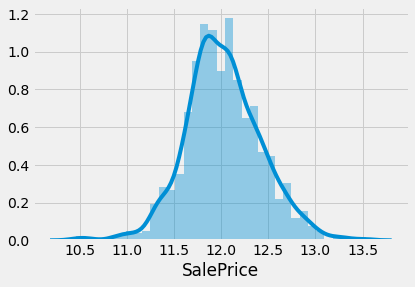

In [64]:
#Visualising Transformed SalePrice. 

sns.distplot(train.loc[:,'SalePrice'], norm_hist=True)

In [56]:
# Skewness and Fisher's Kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())  #Skewness and Kurtosis both have been reduced, and the Saleprice column is now approximately normally distributed.

Skewness: 0.121347
Kurtosis: 0.809519


### Outlier Treatment

In [57]:
def identify_outlier(feature): 
    sorted(feature) 
    lower_range = np.mean(feature) - (3 * np.std(feature)) 
    upper_range = np.mean(feature) + (3 * np.std(feature))  
    #Removing extreme outliers as Mean +- 4*StdDev
    return lower_range,upper_range

lower_range, upper_range = identify_outlier(train['MasVnrArea'])

overall_qual_drop = train[(train['MasVnrArea'] < lower_range) | (train['MasVnrArea'] > upper_range)]


def outlier_removal (df):
    numeric_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea',
'BsmtFullBath','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','SalePrice',
                       'TotBathrooms', 'TotalSF', 'Total_porch_sf']
   #The numerical features for outlier removal were manually selected because mutiple numerical columns have a lot of zeros
   #in them post the missing value treatment, which exclude all the meaningful rows as outliers.
    
    for column in numeric_features:
        lower_range,upper_range = identify_outlier(df[column])
        overall_qual_drop = df[(df[column] < lower_range) | (df[column] > upper_range)]
        df.drop(overall_qual_drop.index, axis=0, inplace=True)
    return df

In [58]:
outlier_removal(train)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,1,0,0,0,1,0,12.247699
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,1,0,0,0,1,0,12.109016
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,1,0,0,0,1,0,12.317171
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,1,0,0,0,0,0,11.849405
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,1,0,0,0,1,0,12.429220
6,17.067704,14.527692,1993,1995,0.000000,1,2,3,3,120.766677,...,0,0,0,1,0,0,0,1,0,11.870607
7,15.904479,13.799374,2004,2005,18.909628,2,2,4,3,184.077240,...,0,0,0,1,0,0,0,1,0,12.634606
8,16.494888,13.861653,1973,1973,21.292508,1,2,3,3,134.521174,...,0,0,0,1,0,0,0,1,0,12.206078
9,12.759261,12.754397,1931,1950,0.000000,1,2,2,3,0.000000,...,0,0,0,1,0,0,0,0,0,11.774528


In [59]:
test.shape, train.shape

((1459, 361), (1303, 362))

### Splitting the dataset to separate Features and Predictor/Target Variable

In [60]:
Y_train = train['SalePrice'].reset_index(drop=True) #Saleprice column
X_train = train.drop(['SalePrice'], axis=1) #Remaining Training dataset

In [61]:
X_train.shape, Y_train.shape

((1303, 361), (1303,))

In [62]:
X_train

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,14.663550,13.424522,2003,2003,19.378556,2,2,3,3,117.855857,...,0,0,0,0,1,0,0,0,1,0
2,16.494888,13.694529,1976,1976,0.000000,1,2,3,3,146.805790,...,0,0,0,0,1,0,0,0,1,0
3,15.044952,14.034135,2001,2002,17.721068,2,2,3,3,91.575280,...,0,0,0,0,1,0,0,0,1,0
4,14.008494,13.683423,1915,1970,0.000000,1,2,2,4,52.776365,...,0,0,0,0,1,0,0,0,0,0
5,16.954472,14.550144,2000,2000,25.323125,2,2,3,3,112.040319,...,0,0,0,0,1,0,0,0,1,0
6,17.067704,14.527692,1993,1995,0.000000,1,2,3,3,120.766677,...,0,0,0,0,1,0,0,0,1,0
7,15.904479,13.799374,2004,2005,18.909628,2,2,4,3,184.077240,...,0,0,0,0,1,0,0,0,1,0
8,16.494888,13.861653,1973,1973,21.292508,1,2,3,3,134.521174,...,0,0,0,0,1,0,0,0,1,0
9,12.759261,12.754397,1931,1950,0.000000,1,2,2,3,0.000000,...,0,0,0,0,1,0,0,0,0,0


In [63]:
Y_train.describe()

count    1303.000000
mean       12.028193
std         0.358705
min        10.933000
25%        11.790565
50%        12.007567
75%        12.264346
max        13.091906
Name: SalePrice, dtype: float64

### Loading the Validation Dataset, test_actual_price.csv

In [64]:
actual_SalePrice_test = pd.read_csv('test_actual_price.csv')

In [65]:
actual_SalePrice_test

,Id,SalePrice
0,1975,615000
1,1664,610000
2,2264,591587
3,2683,584500
4,1678,552000
5,2629,545224
6,2631,535000
7,2295,500067
8,1480,500000
9,2290,492000


In [66]:
test

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1461,16.494888,14.104343,1961,1961,0.000000,1,2,2,3,89.265742,...,0,0,0,0,1,0,0,0,1,0
1462,16.610807,14.551223,1958,1958,14.607283,1,2,2,3,141.193697,...,0,0,0,0,1,0,0,0,1,0
1463,15.784137,14.482938,1997,1998,0.000000,1,2,3,3,127.247678,...,0,0,0,0,1,0,0,0,1,0
1464,16.260927,13.776813,1998,1998,6.148426,1,2,2,3,105.834776,...,0,0,0,0,1,0,0,0,1,0
1465,11.556456,12.345547,1992,1992,0.000000,2,2,3,3,60.360922,...,0,0,0,0,1,0,0,0,1,0
1466,15.904479,13.781514,1993,1994,0.000000,1,2,3,3,0.000000,...,0,0,0,0,1,0,0,0,1,0
1467,14.534537,13.304342,1992,2007,0.000000,1,3,3,3,142.427431,...,0,0,0,0,1,0,0,0,1,0
1468,14.404548,13.412534,1998,1998,0.000000,1,2,3,3,0.000000,...,0,0,0,0,1,0,0,0,1,0
1469,17.067704,13.818779,1990,1990,0.000000,1,2,3,3,109.952166,...,0,0,0,0,1,0,0,0,1,0


## Let the Modelling Begin!!

### Linear Regression Model

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(test)


lin_reg = LinearRegression()

lin_reg = lin_reg.fit(rescaledX_train,Y_train)

y_pred = lin_reg.predict(rescaledX_test)

In [84]:
y_pred

array([-1., inf, -1., ..., inf, -1., -1.])

In [163]:
#10-Fold Cross Validation
cv = KFold(shuffle=True, random_state=2, n_splits=10)

scores = cross_val_score(lin_reg, train, target, cv = cv, scoring = 'neg_mean_absolute_error')

In [164]:
print ('%.8f'%scores.mean())

-0.04317145


In [75]:
print("R2 Square:", metrics.r2_score(actual_SalePrice_test, y_pred))

R2 Square: -49.4462591345135


In [162]:
y_pred

array([8.7463044 , 8.72135725, 8.92407859, ..., 8.66736226, 8.60651286,
       8.65043629])

### Decision Tree

In [83]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#rescaledX_train = scaler.fit_transform(X)
#rescaledX_test = scaler.fit_transform(test)
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

dtr.fit(rescaledX_train,Y_train)
dtr_pred = dtr.predict(rescaledX_test)

In [84]:
dtr_pred

array([11.68267668, 11.88621856, 12.16525586, ..., 12.00089793,
       11.89819467, 12.38839837])

In [85]:
dtr_pred = np.expm1(dtr_pred)

In [86]:
prediction = pd.DataFrame(dtr_pred)

In [87]:
prediction['Id'] = prediction.index+1461

In [88]:
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})

In [89]:
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")

In [90]:
submission

,Predicted_SalePrice,Id,SalePrice
0,118500.000000,1461,105000
1,145250.000000,1462,172000
2,192000.000000,1463,189900
3,179500.000000,1464,195500
4,181000.000000,1465,191500
5,178000.000000,1466,175900
6,193000.000000,1467,185000
7,178900.000000,1468,180400
8,175000.000000,1469,171500
9,155000.000000,1470,126000


In [91]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), dtr_pred))

R2 Square: 0.7592595660720719


In [92]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.16681384210439582


### Random Forest Regression

In [93]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()

rfr.fit(rescaledX_train,Y_train)
rfr_pred = rfr.predict(rescaledX_test)

In [94]:
rfr_pred

array([11.73310641, 11.98809644, 12.11946116, ..., 12.01848979,
       11.67059593, 12.25286131])

In [95]:
rfr_pred = np.expm1(rfr_pred)

In [96]:
prediction = pd.DataFrame(rfr_pred)

In [97]:
prediction['Id'] = prediction.index+1461

In [98]:
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})

In [99]:
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")

In [100]:
submission

,Predicted_SalePrice,Id,SalePrice
0,124629.221728,1461,105000
1,160827.915604,1462,172000
2,183405.662340,1463,189900
3,191814.603590,1464,195500
4,192801.804249,1465,191500
5,179780.371615,1466,175900
6,172775.655500,1467,185000
7,176290.339949,1468,180400
8,183351.677624,1469,171500
9,133057.789575,1470,126000


In [101]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), rfr_pred))

R2 Square: 0.8742829242356946


In [102]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.11038694620121976


### SVR Regression

In [103]:
from sklearn.svm import SVR

regressor = SVR(kernel = 'rbf')

regressor.fit(rescaledX_train,Y_train)

regressor_pred = regressor.predict(rescaledX_test)

In [104]:
regressor_pred

array([11.72902379, 11.98056312, 12.17784518, ..., 12.0246676 ,
       11.70241506, 12.36806352])

In [105]:
regressor_pred = np.expm1(regressor_pred)

In [106]:
prediction = pd.DataFrame(regressor_pred)
prediction['Id'] = prediction.index+1461
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")
submission

,Predicted_SalePrice,Id,SalePrice
0,124121.441258,1461,105000
1,159620.891614,1462,172000
2,194432.440835,1463,189900
3,203421.335325,1464,195500
4,189219.794286,1465,191500
5,177700.701232,1466,175900
6,170385.982900,1467,185000
7,161669.066758,1468,180400
8,180347.941781,1469,171500
9,130789.817652,1470,126000


In [107]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), regressor_pred))

R2 Square: 0.7590055309046861


In [108]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.14099683512945735


### Ridge Regression

In [158]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
ridge = Ridge()

In [159]:
ridge.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'random_state', 'solver', 'tol'])

In [160]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [164]:
std_slc = StandardScaler()
pca = decomposition.PCA()

pipe = Pipeline(steps=[("std_slc", std_slc),
                           ("pca", pca),
                           ("ridge", Ridge)])
    
    
n_components = list(range(1,rescaledX_train.shape[1]+1,1))

normalize = [True, False]
solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]

parameters = dict(pca__n_components=n_components,
                      ridge__normalize=normalize,
                      ridge__solver=solver)

In [165]:
clf_GS = GridSearchCV(pipe, parameters)

In [166]:
clf_GS.fit(rescaledX_train,Y_train)

#yhat = clf_GS.predict(rescaledX_test)


TypeError: get_params() missing 1 required positional argument: 'self'

In [110]:
yhat

array([11.77647009, 11.98519599, 12.18802935, ..., 12.05823655,
       11.77593675, 12.29630794])

In [111]:
yhat = np.expm1(yhat)

In [112]:
prediction = pd.DataFrame(yhat)
prediction['Id'] = prediction.index+1461
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")
submission

,Predicted_SalePrice,Id,SalePrice
0,130152.537126,1461,105000
1,160362.114104,1462,172000
2,196422.702380,1463,189900
3,207109.750671,1464,195500
4,194271.953742,1465,191500
5,168537.328556,1466,175900
6,177117.755765,1467,185000
7,167611.449232,1468,180400
8,184572.176851,1469,171500
9,126418.351676,1470,126000


In [113]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), yhat))

R2 Square: 0.8722017743219934


In [114]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.09721376964226823


### XGBoost Regression

In [115]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=0)

model.fit(rescaledX_train,Y_train)

yhat_l = model.predict(rescaledX_test)

In [116]:
yhat_l

array([11.76658186, 12.01285811, 12.16602421, ..., 12.05049217,
       11.65674663, 12.2283731 ])

In [117]:
yhat_l = np.expm1(yhat_l)

In [118]:
prediction = pd.DataFrame(yhat_l)
prediction['Id'] = prediction.index+1461
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")
submission

,Predicted_SalePrice,Id,SalePrice
0,128871.891803,1461,105000
1,164860.021712,1462,172000
2,192147.580752,1463,189900
3,200736.112481,1464,195500
4,182047.016612,1465,191500
5,174289.407407,1466,175900
6,178313.741134,1467,185000
7,171858.496729,1468,180400
8,180871.827393,1469,171500
9,132912.608737,1470,126000


In [119]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), yhat_l))

R2 Square: 0.8942141665068125


In [120]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.09946640937668944


In [160]:
from sklearn.linear_model import ElasticNet

Eregr = ElasticNet(random_state=0)

Eregr.fit(rescaledX_train,Y_train)

Eregr_pred = Eregr.predict(rescaledX_test)

In [161]:
Eregr_pred

array([12.02819298, 12.02819298, 12.02819298, ..., 12.02819298,
       12.02819298, 12.02819298])

In [156]:
Eregr_pred = np.expm1(Eregr_pred)

In [157]:
prediction = pd.DataFrame(Eregr_pred)
prediction['Id'] = prediction.index+1461
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")
submission

,Predicted_SalePrice,Id,SalePrice
0,128913.482403,1461,105000
1,165097.611020,1462,172000
2,192230.013413,1463,189900
3,200278.923053,1464,195500
4,181658.373063,1465,191500
...,...,...,...
1454,87725.336874,2915,90500
1455,94346.410463,2916,71000
1456,178451.052963,2917,131000
1457,115045.193477,2918,132000


### RidgeCV Regression

In [164]:
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(rescaledX_train,Y_train)

clf = clf.predict(rescaledX_test)

In [165]:
clf

array([11.77670467, 11.98576389, 12.18740357, ..., 12.06009514,
       11.77805959, 12.29353969])

In [167]:
clf = np.expm1(clf)

In [168]:
prediction = pd.DataFrame(clf)
prediction['Id'] = prediction.index+1461
submission = prediction.rename(columns = {0:'Predicted_SalePrice'})
submission = pd.merge(submission, actual_SalePrice_test, how = "inner", on = "Id")
submission

,Predicted_SalePrice,Id,SalePrice
0,130183.072749,1461,105000
1,160453.210436,1462,172000
2,196299.821644,1463,189900
3,207069.946295,1464,195500
4,193728.886510,1465,191500
...,...,...,...
1454,94080.301563,2915,90500
1455,91744.226949,2916,71000
1456,172834.427658,2917,131000
1457,130359.581470,2918,132000


In [169]:
print("R2 Square:", metrics.r2_score(np.array(submission['SalePrice']), clf))

R2 Square: 0.8722286617642048


In [170]:
mape = np.mean(np.abs(submission['SalePrice'] - submission['Predicted_SalePrice']) / submission['SalePrice'])
print(mape)

0.0971553578699511


# Elastic Net

In [ ]:
#en = linear_model.ElasticNetCV()
#en.get_params().keys()